In [1]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "true"
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
# import wandb
from models import Showo, MAGVITv2, get_mask_chedule
from training.prompting_utils import UniversalPrompting, create_attention_mask_predict_next
from training.utils import get_config, flatten_omega_conf, image_transform
from transformers import AutoTokenizer
import torch.nn.functional as F

/home/hpyky/miniconda3/envs/showo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-03-17 21:29:58,033] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/hpyky/miniconda3/envs/showo/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.2
 [WARNING]  using untested triton version (2.2.0), only 1.0.0 is known to be compatible


In [2]:
from omegaconf import DictConfig, ListConfig, OmegaConf
config = OmegaConf.load('configs/showo_demo.yaml')
config.mode = 't2i'
config.batch_size = 1
config.generation_timesteps = 50
config.guidance_scale = 5

In [24]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(config.model.showo.llm_model_path, padding_side="left")

uni_prompting = UniversalPrompting(tokenizer, max_text_len=config.dataset.preprocessing.max_seq_length,
                                    special_tokens=("<|soi|>", "<|eoi|>", "<|sov|>", "<|eov|>", "<|t2i|>", "<|mmu|>", "<|t2v|>", "<|v2v|>", "<|lvg|>"),
                                    ignore_id=-100, cond_dropout_prob=config.training.cond_dropout_prob)

vq_model = MAGVITv2.from_pretrained(config.model.vq_model.vq_model_name).to(device)
vq_model.requires_grad_(False)
vq_model.eval()

model = Showo.from_pretrained(config.model.showo.pretrained_model_path).to(device)
model.eval()

# load from users passed arguments
config.training.batch_size = config.batch_size
config.training.guidance_scale = config.guidance_scale
config.training.generation_timesteps = config.generation_timesteps

Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.


attention implementation:  sdpa


In [25]:
data_root = "/home/hpyky/full_mcdata"
concept = "dunpai"
ckpt_name = "no2"
epoch2load = 400

ckpt_path = os.path.join("saves", concept, ckpt_name)
ckpt_embed_path = os.path.join(ckpt_path, f"epoch_{epoch2load}_embed.pt")
ckpt_lm_head_weight_path = os.path.join(ckpt_path, f"epoch_{epoch2load}_lm_head_weight.pt")
ckpt_lm_head_bias_path = os.path.join(ckpt_path, f"epoch_{epoch2load}_lm_head_bias.pt")

In [26]:
nums_new_token_i = 16

#################################
new_tokens = [f"<{concept}>"] + [f"<token_{i}>" for i in range(nums_new_token_i)]
num_new_tokens = len(new_tokens)  # 17

# 已知的原始参数
# 文本 token 数量（ID 0-50304）
original_text_vocab_size = len(tokenizer)  
# Image token 数量（原 ID 50305-58497）
original_image_vocab_size = model.showo.get_input_embeddings().num_embeddings - len(tokenizer)

original_total_vocab = original_text_vocab_size + original_image_vocab_size  # 58498

# 新的参数
new_text_vocab_size = original_text_vocab_size + num_new_tokens  # 50305 + 17 = 50322
new_total_vocab = original_total_vocab + num_new_tokens          # 58498 + 17 = 58515

# ------------------------------
# Step 1: 修改 Tokenizer 的词汇表
# ------------------------------

# 添加新 token 到 50305-50321 的位置
num_new_tokens = tokenizer.add_tokens(new_tokens)
new_token_ids = tokenizer.convert_tokens_to_ids(new_tokens)
print("新 token ID:", new_token_ids)  # 应输出 50305-50321

# ------------------------------
# Step 2: 调整模型的权重
# ------------------------------
with torch.no_grad():
    # 获取嵌入层权重
    embeddings = model.showo.get_input_embeddings().weight.data
    
    # 扩展嵌入层（58498 -> 58515）
    model.showo.resize_token_embeddings(new_total_vocab)
    # new_embeddings = model.showo.get_input_embeddings().weight.data

    # 将原 Image Token 权重后移 17 位
    original_image_weights = embeddings[original_text_vocab_size:original_total_vocab].clone()
    model.showo.get_input_embeddings().weight.data[new_text_vocab_size:new_total_vocab] = original_image_weights
    
    # 初始化新 token 的权重（用原文本最后 17 个 token）
    if os.path.exists(ckpt_embed_path):
        ckpt_embed_weight = torch.load(ckpt_embed_path)
        with torch.no_grad():
            model.showo.get_input_embeddings().weight.data[original_text_vocab_size:new_text_vocab_size] = ckpt_embed_weight.to(model.showo.get_input_embeddings().weight.device)
    else:
        raise ValueError("Embedding weights do not exist!")
        
    # new_text_weights = embeddings[original_text_vocab_size - num_new_tokens : original_text_vocab_size].clone()
    # model.showo.get_input_embeddings().weight.data[original_text_vocab_size : new_text_vocab_size] = new_text_weights
    # print(model.showo.lm_head.weight.data.shape[1])
    # 处理 lm_head（假设与嵌入层共享权重）
    if model.showo.lm_head.weight.data.shape[0] == new_total_vocab:
        # 扩展 lm_head 权重
        lm_head = model.showo.lm_head
        new_lm_head = torch.nn.Linear(
            lm_head.in_features, 
            new_total_vocab, 
            bias=hasattr(lm_head, 'bias')
        )
        new_lm_head.weight.data = lm_head.weight.data.clone()
        new_lm_head.weight.data[new_text_vocab_size:new_total_vocab] = lm_head.weight.data[original_text_vocab_size:original_total_vocab]
        
        if os.path.exists(ckpt_lm_head_weight_path):
            ckpt_lm_head_weight = torch.load(ckpt_lm_head_weight_path)
            with torch.no_grad():
                new_lm_head.weight.data[original_text_vocab_size:new_text_vocab_size] = ckpt_lm_head_weight.to(new_lm_head.weight.device)
        else:
            raise ValueError("lm_head weights do not exist!")
        # new_lm_head.weight.data[original_text_vocab_size:new_text_vocab_size] = lm_head.weight.data[original_text_vocab_size - num_new_tokens : original_text_vocab_size]
        if hasattr(lm_head, 'bias'):
            new_lm_head.bias.data = lm_head.bias.data.clone()
            new_lm_head.bias.data[new_text_vocab_size:new_total_vocab] = lm_head.bias.data[original_text_vocab_size:original_total_vocab]
            
            if os.path.exists(ckpt_lm_head_bias_path):
                ckpt_lm_head_bias = torch.load(ckpt_lm_head_bias_path)
                with torch.no_grad():
                    new_lm_head.bias.data[original_text_vocab_size:new_text_vocab_size] = ckpt_lm_head_bias.to(new_lm_head.weight.device)
            else:
                raise ValueError("lm_head bias do not exist!")
            # new_lm_head.bias.data[original_text_vocab_size:new_text_vocab_size] = lm_head.bias.data[original_text_vocab_size - num_new_tokens : original_text_vocab_size]
        
        model.showo.lm_head = new_lm_head
    else:
        raise ValueError("lm_head weights do not match the input embeddings!")

index_no_updates = torch.ones((new_total_vocab,), dtype=torch.bool)
index_no_updates[new_token_ids] = False
# ------------------------------
# 验证
# ------------------------------
# 检查新 token 的 ID
print("新增文本 token ID:", [tokenizer.convert_tokens_to_ids(t) for t in new_tokens])  # 应输出 50305-50321

# 检查一个原 Image Token 的新 ID
sample_image_token = tokenizer.convert_ids_to_tokens(original_text_vocab_size)  # 原 ID 50305
print(f"Concept Token '{sample_image_token}' 的新 ID:", tokenizer.convert_tokens_to_ids(sample_image_token))  # 应输出 50322

# 检查嵌入层形状
print("嵌入层大小:", model.showo.get_input_embeddings().weight.shape)  # 应显示 torch.Size([58515, 2048])

# 检查 index_no_updates 中 True 的位置和数量，True 应该是 new token ids
print("index_no_updates 中 False 的位置:", torch.nonzero(~index_no_updates).squeeze())  # 应输出 50305-50321
print("index_no_updates 中 True 的数量:", torch.sum(index_no_updates))  # 应输出 58498



新 token ID: [50305, 50306, 50307, 50308, 50309, 50310, 50311, 50312, 50313, 50314, 50315, 50316, 50317, 50318, 50319, 50320, 50321]
新增文本 token ID: [50305, 50306, 50307, 50308, 50309, 50310, 50311, 50312, 50313, 50314, 50315, 50316, 50317, 50318, 50319, 50320, 50321]
Concept Token '<dunpai>' 的新 ID: 50305
嵌入层大小: torch.Size([58515, 2048])
index_no_updates 中 False 的位置: tensor([50305, 50306, 50307, 50308, 50309, 50310, 50311, 50312, 50313, 50314,
        50315, 50316, 50317, 50318, 50319, 50320, 50321])
index_no_updates 中 True 的数量: tensor(58498)


In [27]:
model.config.mask_token_id = model.showo.get_input_embeddings().num_embeddings - 1
mask_token_id = model.showo.get_input_embeddings().num_embeddings - 1
config.model.showo.llm_vocab_size = len(tokenizer) - 10


In [28]:
from peft import PeftModel
model.showo = PeftModel.from_pretrained(model.showo, os.path.join("saves", concept, ckpt_name, f"epoch_{epoch2load}_lora_model"))

In [29]:
model

Showo(
  (showo): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): PhiForCausalLM(
        (model): PhiModel(
          (embed_tokens): Embedding(58515, 2048)
          (embed_dropout): Dropout(p=0.0, inplace=False)
          (layers): ModuleList(
            (0-23): 24 x PhiDecoderLayer(
              (self_attn): PhiSdpaAttention(
                (q_proj): lora.Linear(
                  (base_layer): Linear(in_features=2048, out_features=2048, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=2048, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_features=2048, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
                  (lora_embedding_B): ParameterDict()
                )


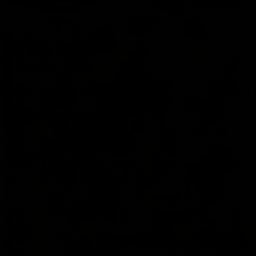

In [32]:
step = 0
# prompt = "<dunpai> is <token_0><token_1><token_2><token_3><token_4><token_5><token_6><token_7><token_8><token_9><token_10><token_11><token_12><token_13><token_14><token_15>.\nA photo of <dunpai>."
# prompt = "<dunpai> is <token_0><token_1><token_2><token_3><token_4><token_5><token_6><token_7><token_8><token_9><token_10><token_11><token_12><token_13><token_14><token_15>.\nA photo of <dunpai>."
# prompt = "<dunpai> is <token_0><token_1><token_2><token_3><token_4><token_5><token_6><token_7><token_8><token_9><token_10><token_11><token_12><token_13><token_14><token_15>.\nA photo of <dunpai>."
# prompt = "A man with <dunpai><token_0><token_1><token_2><token_3><token_4><token_5><token_6><token_7><token_8><token_9><token_10><token_11><token_12><token_13><token_14><token_15>."
# prompt = "A photo of <token_0><token_1><token_2><token_3><token_4><token_5><token_6><token_7><token_8><token_9><token_10><token_11><token_12><token_13><token_14><token_15>."
prompt = "A photo of <dunpai>"
prompt = ""
prompt = "A photo of a dog"

image_tokens = torch.ones((1, config.model.showo.num_vq_tokens),
                            dtype=torch.long, device=device) * mask_token_id    # shape [batch, num_vq_tokens] [1, 256], fill with mask token
# mask id == 58497
# id 50295 == [PAD]
# id 50256 == <|endoftext|>
# id 50300 == <|t2i|>
# id 50296 == <|soi|>
# id 50297 == <|eoi|>

input_ids, _ = uni_prompting(([prompt], image_tokens), 't2i_gen')   # [1, 387]
# [1, 387], prompt == A cute dog, == [PAD] * 123 + <|t2i|><|endoftext|> + prompt + <|endoftext|><|soi|> + [MASK] * 256 + <|eoi|>
# [1, 387], prompt == A cute dog, == [PAD] * 120 + <|t2i|><|endoftext|> + prompt + <|endoftext|><|soi|> + [MASK] * 256 + <|eoi|>

if config.training.guidance_scale > 0:
    uncond_input_ids, _ = uni_prompting(([''] * 1, image_tokens), 't2i_gen')
    # [1, 387], == [PAD] * 126 + <|t2i|> + <|endoftext|> + <|endoftext|> + <|soi|> + [MASK] * 256 + <|eoi|> ## no prompt
    attention_mask = create_attention_mask_predict_next(torch.cat([input_ids, uncond_input_ids], dim=0),    # [2, 387]
                                                        pad_id=int(uni_prompting.sptids_dict['<|pad|>']),
                                                        soi_id=int(uni_prompting.sptids_dict['<|soi|>']),
                                                        eoi_id=int(uni_prompting.sptids_dict['<|eoi|>']),
                                                        rm_pad_in_image=True)
else:
    attention_mask = create_attention_mask_predict_next(input_ids,
                                                        pad_id=int(uni_prompting.sptids_dict['<|pad|>']),
                                                        soi_id=int(uni_prompting.sptids_dict['<|soi|>']),
                                                        eoi_id=int(uni_prompting.sptids_dict['<|eoi|>']),
                                                        rm_pad_in_image=True)
    uncond_input_ids = None
# attention_mask [2, 1, 387, 387]

if config.get("mask_schedule", None) is not None:
    schedule = config.mask_schedule.schedule
    args = config.mask_schedule.get("params", {})
    mask_schedule = get_mask_chedule(schedule, **args)
else:
    mask_schedule = get_mask_chedule(config.training.get("mask_schedule", "cosine"))


with torch.no_grad():
    gen_token_ids = model.t2i_generate(
        input_ids=input_ids,
        uncond_input_ids=uncond_input_ids,
        attention_mask=attention_mask,
        guidance_scale=config.training.guidance_scale,
        temperature=config.training.get("generation_temperature", 1.0),
        timesteps=config.training.generation_timesteps,
        noise_schedule=mask_schedule,
        noise_type=config.training.get("noise_type", "mask"),
        seq_len=config.model.showo.num_vq_tokens,
        uni_prompting=uni_prompting,
        config=config,
    )
gen_token_ids = torch.clamp(gen_token_ids, max=config.model.showo.codebook_size - 1, min=0)
images = vq_model.decode_code(gen_token_ids)


images = torch.clamp((images + 1.0) / 2.0, min=0.0, max=1.0)
images *= 255.0
images = images.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
pil_images = [Image.fromarray(image) for image in images]

pil_images[0].show()